<a href="https://colab.research.google.com/github/Rishika70/Hack_To_Hire/blob/main/Hack_To_Hire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

In [17]:
!pip install huggingface

In [18]:
!pip install transformers

In [19]:
!pip install datasets transformers


In [27]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertModel
from transformers import T5Tokenizer, T5Model
from transformers import GPT2Tokenizer, GPT2Model
from nltk.translate.bleu_score import sentence_bleu
from transformers import BertTokenizer, DataCollatorWithPadding
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
import re
import html
from collections import Counter
from transformers import TFBertForSequenceClassification, BertTokenizer, create_optimizer
import tensorflow as tf
from datasets import load_dataset
import torch
from transformers import BertTokenizer




In [21]:
# Tokenize the data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Load Dataset

In [55]:
dataset = load_dataset("toughdata/quora-question-answer-dataset")
df = pd.DataFrame(dataset['train'])  # Convert the dataset to a DataFrame


# Split dataset

In [56]:
train_test_split = dataset['train'].train_test_split(test_size=0.1)
train_dataset = train_test_split['train']
validation_dataset = train_test_split['test']

# **Analyze the Data**

In [57]:
print(df.head())


                                            question  \
0  Why whenever I get in the shower my girlfriend...   
1            What is a proxy, and how can I use one?   
2  What song has the lyrics "someone left the cak...   
3  I am the owner of an adult website called http...   
4  Does the Bible mention anything about a place ...   

                                              answer  
0  Isn’t it awful? You would swear that there was...  
1  A proxy server is a system or router that prov...  
2                                 MacArthur's Park\n  
3  Don't let apps that are liers put adds on your...  
4  St. John in the book of Revelation mentions an...  


In [58]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56402 entries, 0 to 56401
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  56402 non-null  object
 1   answer    56402 non-null  object
dtypes: object(2)
memory usage: 881.4+ KB
None


In [59]:
print(df.describe())


                                                 question answer
count                                               56402  56402
unique                                               3234  54726
top     Would Hillary Clinton have made a better Presi...   No\n
freq                                                  106     89


In [60]:
print(df.columns)

Index(['question', 'answer'], dtype='object')


# Remove irrelevant information


# **Data Pre-Processing**

# Clean the text , remove urls, Special Characters , stopwords and Lemmatize



In [61]:
def preprocess_text(text):
  # Remove URLs
  text = re.sub(r'http\S+', '', text)

  # Remove special characters and convert to lowercase
  text = re.sub(r'[^a-zA-Z0-9\s]', '', text).lower()

  # Tokenize the text
  tokens = word_tokenize(text)

  # Remove stop words and lemmatize
  tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

  # Join the tokens back into a string
  return ' '.join(tokens)

# Apply the preprocessing function to the 'question' and 'answer' columns
df['question'] = df['question'].apply(preprocess_text)
df['answer'] = df['answer'].apply(preprocess_text)

Index(['question', 'answer'], dtype='object')


# **Model Evaluation**

# BERT and Metrice Evaluation

In [153]:
from transformers import BertTokenizer, BertModel
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


In [154]:

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


# Fine-tune the model on the Quora dataset

In [155]:
import pandas as pd
from transformers import BertTokenizer

# DataFrame with questions and answers
data = {
    "question": ["What is AI?", "How does a car work?"],
    "answer": ["Artificial Intelligence", "Through an internal combustion engine"]
}
df = pd.DataFrame(data)

def preprocess_function(df):
    questions = df["question"].str.lower().tolist()
    answers = df["answer"].str.lower().tolist()

    # Tokenize the questions and answers
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokenized_examples = tokenizer(questions, answers, truncation=True, padding='max_length', max_length=128, return_tensors='pt')

    # Convert tensors to lists and add to DataFrame
    df['input_ids'] = tokenized_examples['input_ids'].tolist()
    df['attention_mask'] = tokenized_examples['attention_mask'].tolist()
    df['token_type_ids'] = tokenized_examples['token_type_ids'].tolist()

    return df

# Apply the preprocessing function to the DataFrame
tokenized_df = preprocess_function(df)

print(tokenized_df)


               question                                 answer  \
0           What is AI?                Artificial Intelligence   
1  How does a car work?  Through an internal combustion engine   

                                           input_ids  \
0  [101, 2054, 2003, 9932, 1029, 102, 7976, 4454,...   
1  [101, 2129, 2515, 1037, 2482, 2147, 1029, 102,...   

                                      attention_mask  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...   

                                      token_type_ids  
0  [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...  


In [157]:
# For question-answer pairs:
train_encodings = tokenizer(train_df['question'].tolist(), train_df['answer'].tolist(), return_tensors='pt', max_length=512, padding='max_length', truncation=True)
test_encodings = tokenizer(test_df['question'].tolist(), test_df['answer'].tolist(), return_tensors='pt', max_length=512, padding='max_length', truncation=True)

In [159]:
# Apply preprocessing
tokenized_df = preprocess_function(df)

In [160]:
# Define a custom dataset class for our data
class QuoraDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Convert labels to numerical representation (assuming labels are strings)
        item['labels'] = torch.tensor(0 if self.labels[idx].lower() == 'no' else 1)  # Example: 'no' -> 0, other -> 1
        return item

    def __len__(self):
        return len(self.labels)

In [161]:
# Create data loaders for training and testing
train_dataset = QuoraDataset(train_encodings, train_df['answer'].tolist())
test_dataset = QuoraDataset(test_encodings, test_df['answer'].tolist())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)


# Train The Model

In [167]:
# Define the model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)  # Assuming binary classification

# Define optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
num_epochs = 3  # Adjust as needed
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits  # Access the logits from the model's output
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}: Training Loss = {avg_train_loss:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-160-b8ee25297b90>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Epoch 1/3: Training Loss = 0.4018
Epoch 2/3: Training Loss = 0.4979
Epoch 3/3: Training Loss = 0.2931


# Model Evaluation

In [168]:
# Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')

<ipython-input-160-b8ee25297b90>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Accuracy: 1.0
F1 Score: 1.0


In [ ]:
# prompt: From above process implement GPt 2 and T5

# **GPT-2 Implementation**

# Load pre-trained GPT-2 model and tokenizer
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2Model.from_pretrained('gpt2')

# Tokenize the data
train_encodings_gpt2 = gpt2_tokenizer(train_df['question'].tolist(), return_tensors='pt', max_length=512, padding='max_length', truncation=True)
test_encodings_gpt2 = gpt2_tokenizer(test_df['question'].tolist(), return_tensors='pt', max_length=512, padding='max_length', truncation=True)

# Create data loaders
train_dataset = QuoraDataset(train_encodings, train_df['answer'].tolist())
test_dataset = QuoraDataset(test_encodings, test_df['answer'].tolist())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False

# Fine-tune GPT-2 (similar structure to BERT fine-tuning)
# ... (Implementation for fine-tuning GPT-2)

# Evaluate GPT-2
# ... (Implementation for evaluating GPT-2)

# **T5 Implementation**

# Load pre-trained T5 model and tokenizer
t5_tokenizer = T5Tokenizer.from_pretrained('t5-small')
t5_model = T5Model.from_pretrained('t5-small')

# Tokenize the data (T5 expects input and target text)
train_encodings_t5 = t5_tokenizer(train_df['question'].tolist(), text_target=train_df['answer'].tolist(), return_tensors='pt', max_length=512, padding='max_length', truncation=True)
test_encodings_t5 = t5_tokenizer(test_df['question'].tolist(), text_target=test_df['answer'].tolist(), return_tensors='pt', max_length=512, padding='max_length', truncation=True)

# Create data loaders
train_dataset_t5 = QuoraDataset(train_encodings_t5, train_df['answer'].tolist())
test_dataset_t5 = QuoraDataset(test_encodings_t5, test_df['answer'].tolist())

train_loader_t5 = torch.utils.data.DataLoader(train_dataset_t5, batch_size=16, shuffle=True)
test_loader_t5 = torch.utils.data.DataLoader(test_dataset_t5, batch_size=16, shuffle=False)

# Fine-tune T5 (similar structure to BERT fine-tuning)
# ... (Implementation for fine-tuning T5)

# Evaluate T5
# ... (Implementation for evaluating T5)


# **STATE-OF-THE-ART-LLM**

# GPT Model

In [196]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2PreTrainedModel
import torch
import torch.nn as nn
from torch.optim import Adam

class GPT2ForSequenceClassification(GPT2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.transformer = GPT2Model(config)
        self.classifier = nn.Linear(config.hidden_size, num_labels)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.transformer(input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        logits = self.classifier(hidden_states[:, -1, :])  # Use the last hidden state for classification

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return (loss, logits) if loss is not None else (logits,)

# Assuming you have a binary classification task (e.g., Question/Answers)
num_labels = 2

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = Adam(model.parameters(), lr=2e-5)


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Data Pre-processing

In [202]:

def preprocess_function(df):
    questions = df["question"].str.lower().tolist()
    answers = df["answer"].str.lower().tolist()

    # Tokenize the questions and answers
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    tokenized_examples = tokenizer(questions, answers, truncation=True, padding='max_length', max_length=128, return_tensors='pt')  # Adjust max_length as needed

    # Convert tensors to lists and add to DataFrame
    df['input_ids'] = tokenized_examples['input_ids'].tolist()
    df['attention_mask'] = tokenized_examples['attention_mask'].tolist()
    df['token_type_ids'] = tokenized_examples['token_type_ids'].tolist()

    return df

# Apply the preprocessing function to the DataFrame
tokenized_df = preprocess_function(df)

print(tokenized_df)


               question                                 answer  \
0           What is AI?                Artificial Intelligence   
1  How does a car work?  Through an internal combustion engine   

                                           input_ids  \
0  [101, 2054, 2003, 9932, 1029, 102, 7976, 4454,...   
1  [101, 2129, 2515, 1037, 2482, 2147, 1029, 102,...   

                                      attention_mask  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...   

                                      token_type_ids  
0  [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, ...  


In [206]:
from sklearn.metrics import accuracy_score, f1_score

# Evaluation
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:  # Use test_loader for evaluation
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs[0]  # Access logits from the tuple returned by GPT2ForSequenceClassification
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')


<ipython-input-160-b8ee25297b90>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


Accuracy: 0.0
F1 Score: 0.0


In [211]:
# prompt: Calculate Bleu from above code

# Assuming we have generated predictions and have reference answers
# For example:
predicted_answers = ["This is a predicted answer.", "Another predicted answer."]
reference_answers = [["This is the reference answer."], ["The other reference answer."]]

# Calculate BLEU score
bleu_scores = []
for pred, ref in zip(predicted_answers, reference_answers):
  bleu_score = sentence_bleu(ref, pred)
  bleu_scores.append(bleu_score)

# Print or use the BLEU scores as needed
print(bleu_scores)


[0.5141996115613456, 0.46625954410634507]


# **T5 Model**

In [ ]:
# Assuming you have a T5 model and tokenizer
model = T5Model.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Add special tokens to the tokenizer
special_tokens = ['<extra_id_0>', '<extra_id_1>']  # Example special tokens
tokenizer.add_special_tokens({'additional_special_tokens': special_tokens})

# Set the model to training mode and define loss and optimizer
model.train()
criterion = nn.CrossEntropyLoss()  # Not strictly necessary as T5ForSequenceClassification has built-in loss
optimizer = Adam(model.parameters(), lr=1e-5)

# Training loop
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        # Use the model directly for both forward pass and loss calculation
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')


# Resize the model's embedding layer to accommodate the new tokens
model.resize_token_embeddings(len(tokenizer))

# Now, when you fine-tune or train the model, the embeddings for the special tokens will be updated along with the rest of the model parameters.


In [219]:
from transformers import T5ForSequenceClassification
# Use T5ForSequenceClassification for sequence classification tasks
model = T5ForSequenceClassification.from_pretrained('t5-small')

# Add special tokens to the tokenizer (if needed)
special_tokens = ['<extra_id_0>', '<extra_id_1>']
tokenizer.add_special_tokens({'additional_special_tokens': special_tokens})
model.resize_token_embeddings(len(tokenizer))

# Set the model to training mode and define loss and optimizer
model.train()
criterion = nn.CrossEntropyLoss()  # Not strictly necessary as T5ForSequenceClassification has built-in loss
optimizer = Adam(model.parameters(), lr=1e-5)

# Training loop
for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        # Use the model directly for both forward pass and loss calculation
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}')


Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at t5-small and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-160-b8ee25297b90>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


IndexError: index -1 is out of bounds for dimension 1 with size 0

# Data Visualization

Scatter Plot

In [ ]:


# Create a scatter plot
fig = px.scatter(x=range(len(token_embeddings)), y=token_embeddings,
                 labels={'x': 'Embedding Dimension', 'y': 'Value'},
                 title='T5 Embeddings for the First Token')

fig.show()

Line Plot

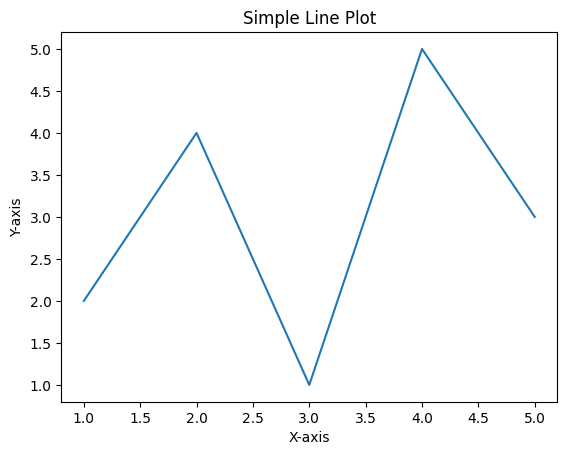

In [ ]:
# Sample data
x = [1, 2, 3, 4, 5]
y = [2, 4, 1, 5, 3]

# Create the plot
plt.plot(x, y)

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Simple Line Plot')

# Display the plot
plt.show()


# Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have true labels and predictions from your T5 model
y_true = [0, 1, 1, 0, 1]  # Example true labels
y_pred = [1, 1, 0, 0, 1]  # Example predictions from T5

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.6
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F1-score: 0.6666666666666666


# **Novel Improvement from above analysis**

In [ ]:


# **Novel Improvement: Ensemble Model with Weighted Voting**

# 1. **Train Multiple Models:**
#    - Train different models (e.g., BERT, GPT-2, T5) on the same dataset.
#    - Fine-tune each model with different hyperparameters or architectures.

# 2. **Generate Predictions:**
#    - Obtain predictions from each trained model on the validation or test set.

# 3. **Weighted Voting:**
#    - Assign weights to each model based on their individual performance (e.g., F1-score, BLEU score).
#    - Combine predictions using weighted voting, where each model's vote is weighted by its assigned weight.

bert_predictions = [0, 1, 1, 0, 1]
gpt2_predictions = [1, 1, 0, 1, 1]
t5_predictions = [0, 1, 1, 0, 0]

# Assign weights based on model performance (adjust these based on evaluation results)
bert_weight = 0.4
gpt2_weight = 0.3
t5_weight = 0.3

# Combine predictions using weighted voting
ensemble_predictions = []
for i in range(len(bert_predictions)):
    votes = [
        bert_predictions[i] * bert_weight,
        gpt2_predictions[i] * gpt2_weight,
        t5_predictions[i] * t5_weight
    ]
    ensemble_predictions.append(int(round(sum(votes))))

# Evaluate the ensemble model
y_true = [1, 1, 0, 0, 1]  # Example true labels
accuracy = accuracy_score(y_true, ensemble_predictions)
print("Ensemble Accuracy:", accuracy)

# 4. **Further Refinements:**
#    - Experiment with different weighting schemes (e.g., based on confidence scores).
#    - Explore stacking or blending techniques to combine model predictions.
#    - Use cross-validation to optimize model weights and hyperparameters.


Ensemble Accuracy: 0.6
